In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv('data/is_ethicity_superior_meaning|is_ethicity_aggressor_meaning|is_ethicity_dangerous_meaning_unique_lemm_text.csv')
data.head()

,document.id,eth_group_to_code,lemm_text,is_ethicity_superior_meaning,is_ethicity_aggressor_meaning,is_ethicity_dangerous_meaning
0,883,монгол,монгол музыка китай древний мирова музыкальный...,irrel,irrel,no
1,883,тибетец,тибетец музыка китай древний мирова музыкальны...,irrel,irrel,no
2,9333,калмык,калмык счастливый калмычка поклонник кушать то...,irrel,irrel,no
3,12039,кавказец,кавказец максимальный репост друг позавчера де...,irrel,irrel,no
4,22019,великоросс,великоросс северный олень бесенок рыжий низкий...,irrel,irrel,no


In [3]:
from sklearn.preprocessing import LabelEncoder

def encode_columns(data, columns):
    encoders = []
    labels = []
    for column in columns:
        le = LabelEncoder()
        data[f'label_{column}'] = le.fit_transform(data[column].values)
        encoders.append(le)
        labels.append(f'label_{column}')
        
    return data, encoders, labels

data, encoders, labels = encode_columns(data, ['is_ethicity_superior_meaning',
                                           'is_ethicity_aggressor_meaning',
                                           'is_ethicity_dangerous_meaning'])

In [4]:
from transformers import AutoTokenizer
from tqdm.notebook import tqdm_notebook
from sklearn.feature_extraction.text import TfidfVectorizer
import torch

def feature_extraction(data, of_type):
    if of_type == 'tfidf':
        vectorizer = TfidfVectorizer(min_df=1, max_df=1.0, ngram_range=(1, 1), max_features=300)
        X = vectorizer.fit_transform(data)
        
        return torch.tensor(X.todense()), None, vectorizer
    
    if of_type == 'bert_tokenizer':
        
#         checkpoint = 'cointegrated/rubert-tiny-sentiment-balanced'
#         checkpoint = 's-nlp/russian_toxicity_classifier'
        checkpoint = 'cointegrated/rubert-tiny-toxicity'
        tokenizer =  AutoTokenizer.from_pretrained(checkpoint)
        
        # Перевожу все в токены
        input_ids = []
        attention_masks = []
        MAX_LENGTH = 256 # Можно будет увеличить до 512, чтобы вместить весь датасет
        for sent in tqdm_notebook(data):
            encoded_dict = tokenizer.encode_plus(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                                max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                                pad_to_max_length = True,
                                return_attention_mask = True,   # Construct attn. masks.
                                return_tensors = 'pt',     # Return pytorch tensors.
                           )

            input_ids.append(encoded_dict['input_ids'])
            attention_masks.append(encoded_dict['attention_mask'])

        input_ids = torch.cat(input_ids, dim=0)
        attention_masks = torch.cat(attention_masks, dim=0)
    
        return input_ids, attention_masks, tokenizer
    
X, _, tokenizer = feature_extraction(data['lemm_text'], 'tfidf')
y = data[labels].values

2023-06-11 14:21:41.117342: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-11 14:21:41.582653: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
k = 2

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X.numpy(), y[:, k], test_size=0.2,
                                                    stratify=y[:, k], random_state=42)


In [7]:
d = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)

In [8]:
X.shape

torch.Size([21485, 300])

In [9]:
from sklearn.utils import resample

res = []
res_y = []

max_samples = np.unique(y_train, return_counts=True)[1].max() // 2

for c in np.unique(y_train):
    print(c)
    some_data = resample(d,
                 replace=True,
                 n_samples=max_samples,
                 random_state=42)

    res.append(some_data)
# X_train = res

0
1
2


In [10]:
res = np.concatenate(res)
X_train = res[:, :-1]
y_train = res[:, -1]

In [15]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3, weights='distance')
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=3, weights='distance')

In [16]:
from sklearn.metrics import f1_score
pred = neigh.predict(X_test)
f1_score(y_test, pred, average='macro')

0.4966607259950095

In [19]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix

print(metrics.classification_report(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

NameError: name 'pred' is not defined

In [24]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=100)
lr.fit(X_train, y_train)

/home/boris/anaconda3/envs/barsik_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [25]:
pred = lr.predict(X_test)
print(metrics.classification_report(y_test, pred))
print(metrics.confusion_matrix(y_test, pred))

              precision    recall  f1-score   support

           0       0.35      0.07      0.12       390
           1       0.89      0.98      0.93      7545
           2       0.35      0.12      0.18       677

    accuracy                           0.87      8612
   macro avg       0.53      0.39      0.41      8612
weighted avg       0.82      0.87      0.83      8612

[[  27  350   13]
 [  43 7364  138]
 [   7  589   81]]


In [14]:
import optuna
from optuna.samplers import TPESampler
import catboost
import pickle
from catboost import CatBoostClassifier
from catboost import Pool

In [30]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data[['lemm_text']], y[:, k], test_size=0.2,
                                                    stratify=y[:, k], random_state=42)

In [15]:
train_pool = Pool(
    X_train, y_train, 
#     text_features=['lemm_text'],
)

validation_pool = Pool(
    X_test, y_test, 
#     text_features=['lemm_text'],
)

print('Train dataset shape: {}\n'.format(train_pool.shape))

Train dataset shape: (34444, 300)



In [16]:
def objective(trial):
    model = catboost.CatBoostClassifier(
        iterations=trial.suggest_int("iterations", 1000, 5000),
        learning_rate=trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True),
        depth=trial.suggest_int("depth", 4, 11),
        l2_leaf_reg=trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
        bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
        random_strength=trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
        bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0),
        od_type=trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
        od_wait=trial.suggest_int("od_wait", 10, 50),
        verbose=2000,
        task_type='GPU',
        random_seed=42,
        eval_metric='TotalF1'
    )
    model.fit(train_pool)
    y_pred = model.predict(X_test)
    f1_score_acc = f1_score(y_pred, y_test, average='macro')
    print(f1_score_acc)
    return f1_score_acc

In [ ]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

sampler = TPESampler(seed=1)
study = optuna.create_study(study_name="catboost", direction="maximize", sampler=sampler)
study.optimize(objective, n_trials=100)

0:	learn: 0.8185347	total: 4.02ms	remaining: 10.7s
2000:	learn: 0.7514228	total: 5.95s	remaining: 1.98s
2667:	learn: 0.8041604	total: 7.96s	remaining: 0us
0.347531161572723
0:	learn: 0.8263258	total: 22.4ms	remaining: 1m 10s
2000:	learn: 0.8071706	total: 42.2s	remaining: 24.4s
3154:	learn: 0.8222610	total: 1m 3s	remaining: 0us
0.3975794718592011
0:	learn: 0.8182667	total: 30.2ms	remaining: 47.1s
1560:	learn: 0.8182667	total: 47.5s	remaining: 0us
0.31132017082379154
0:	learn: 0.8185204	total: 55.8ms	remaining: 1m 4s
1155:	learn: 0.8040789	total: 1m 5s	remaining: 0us
0.38064090338043677
0:	learn: 0.8182667	total: 3.93ms	remaining: 14.7s
2000:	learn: 0.8208963	total: 5.57s	remaining: 4.86s
3745:	learn: 0.8242208	total: 10.4s	remaining: 0us
0.3198861445143043
0:	learn: 0.8223399	total: 6.35ms	remaining: 17.7s
2000:	learn: 0.8102737	total: 11.6s	remaining: 4.59s
2791:	learn: 0.7906248	total: 16.2s	remaining: 0us
0.36063301065510456
0:	learn: 0.8182667	total: 11.1ms	remaining: 32.8s
2000:	le

2000:	learn: 0.8835646	total: 1m 50s	remaining: 31.8s
2574:	learn: 0.8939688	total: 2m 22s	remaining: 0us
0.4178491715981161
0:	learn: 0.8185473	total: 55.6ms	remaining: 3m 19s
2000:	learn: 0.8975400	total: 1m 50s	remaining: 1m 28s
3592:	learn: 0.9134481	total: 3m 18s	remaining: 0us
0.4347576720681134
0:	learn: 0.8185348	total: 30.4ms	remaining: 31.5s
1038:	learn: 0.8506814	total: 31.5s	remaining: 0us
0.3603813937811733
0:	learn: 0.8182667	total: 5.88ms	remaining: 21.1s
2000:	learn: 0.8311727	total: 7.22s	remaining: 5.72s
3586:	learn: 0.8437654	total: 12.9s	remaining: 0us
0.35266737060791153
0:	learn: 0.8203027	total: 32.2ms	remaining: 1m 34s
2000:	learn: 0.8734772	total: 1m	remaining: 28.4s
2938:	learn: 0.8899719	total: 1m 28s	remaining: 0us
0.4099391273868305
0:	learn: 0.8233595	total: 20.9ms	remaining: 1m 26s
2000:	learn: 0.8564741	total: 35.3s	remaining: 38s
4000:	learn: 0.8835152	total: 1m 10s	remaining: 2.65s
4151:	learn: 0.8846896	total: 1m 12s	remaining: 0us
0.40595238158644126

In [33]:
data

,document.id,source_text,is_ethicity_superior_meaning,is_ethicity_aggressor_meaning,is_ethicity_dangerous_meaning
0,883,Музыка Китая – одна из древнейших в мировой му...,irrel,irrel,no
1,9333,"Счастливая калмычка, не та, у которой много по...",irrel,irrel,no
2,12039,"МАКСИМАЛЬНЫЙ РЕПОСТ: Друзья, позавчера днём на...",irrel,irrel,no
3,17208,"Быт и нрав настоящих охотников, рыболовов и об...",high,irrel,no
4,19367,"В фильме показано то, как жиды сегодня искажаю...",low,agressor,no
...,...,...,...,...,...
10720,1122171044,<b>Казаки</b> ЛНР посмеялось над украми и заяв...,irrel,irrel,yes
10721,1123084653,"[[id150675925|Albina], <b>татары</b> если и но...",irrel,irrel,no
10722,1123674377,Да у Вас всегда так. Если Русский или Украинец...,high,agressor,yes
10723,1124349956,Сегодня в драке между армянами и азербайджанца...,irrel,agressor,irrel


In [36]:
data['source_text'].loc[10722]

'Да у Вас всегда так. Если Русский или Украинец или Белорус- герой и патриот,который убивал ради величия своего народа и был убит самыми злыми врагами в мире,а Башкир,<b>Татар</b> и Казах или другие народы- разбойники, которые вели беспощадное истребление мирного населения. Откройте глаза,господа хорошие. Читайте документальную литературу.'

In [39]:
# texts_and_metadata = pd.read_csv('data/file1_14998_texts_and_metadata.txt', sep='\t')
texts_and_metadata[texts_and_metadata['document.id'] == 1124349956]

,document.id,source,stage,source_text,lemm_text,city,region,date
12397,1124349956,iqbuzz,3,Сегодня в драке между армянами и азербайджанца...,сегодня драка между армянин азербайджанец поги...,Самара,Самарская область,2015-12-11


In [40]:
# coding_results = pd.read_csv('data/file2_14998_coding_results.txt', sep='\t')
coding_results[coding_results['document.id'] == 1124349956]

,document.id,source,stage,data,assessor,seed_eth_group,for_questions_about_text,do_text_make_sense_raw,do_text_make_sense_recoded,has_ethnonym_raw,...,represent_ethicity_raw,represent_ethicity_meaning,is_ethicity_superior_raw,is_ethicity_superior_meaning,is_ethicity_aggressor_raw,is_ethicity_aggressor_meaning,is_ethicity_dangerous_raw,is_ethicity_dangerous_meaning,comment,old_id
51192,1124349956,iqbuzz,3,2017-04-03 09:14:44,DariaN,кабардинец,1,yes,1,several,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1124349956
51193,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,1,yes,1,several,...,1.0,no,3.0,irrel,2.0,agressor,1.0,no,NaN,1124349956
51194,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,NaN,1124349956
51195,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,3.0,irrel,NaN,1124349956
51196,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,3.0,irrel,NaN,1124349956
51197,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,1.0,victim,1.0,no,NaN,1124349956
51198,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,1124349956
51199,1124349956,iqbuzz,3,2017-03-26 23:29:24,Tatiana,кабардинец,0,yes,1,several,...,1.0,no,3.0,irrel,3.0,irrel,1.0,no,NaN,1124349956
51200,1124349956,iqbuzz,3,2017-03-16 22:22:00,skuchilina,кабардинец,1,lang,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1124349956


In [25]:
data['flag'] = data['lemm_text'].apply(lambda x: 1 if 'умри' in x else 0)

<Axes: >

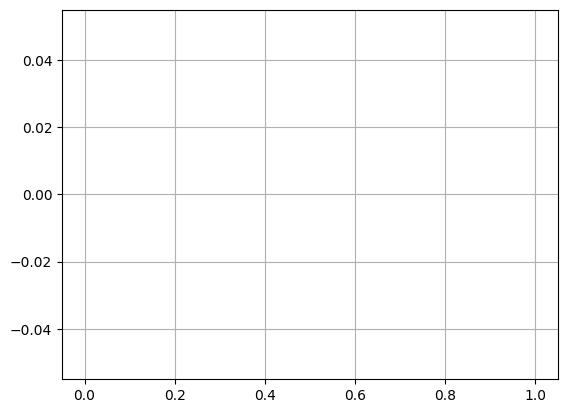

In [26]:
data[data['flag'] == 1]['is_ethicity_superior_meaning'].hist()

<Axes: >

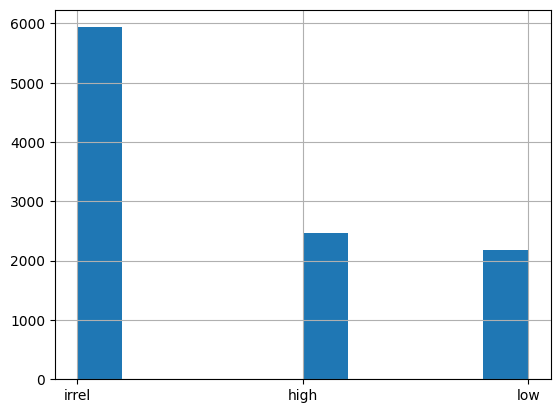

In [24]:
data[data['flag'] == 0]['is_ethicity_superior_meaning'].hist()

In [5]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer('spacy', language='ru')
train_iter = AG_NEWS(split='train')

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

ValueError: Requested tokenizer ru_core_news_sm, valid choices are a callable that takes a single string as input, "revtok" for the revtok reversible tokenizer, "subword" for the revtok caps-aware tokenizer, "spacy" for the SpaCy English tokenizer, or "moses" for the NLTK port of the Moses tokenization script.

In [9]:
from spacy.lang.ru import Russian

nlp = Russian()
doc = nlp("Съешь ещё этих мягких французских булок, да выпей чаю.")


Съешь ещё этих мягких французских булок, да выпей чаю.